### Anticipating what can go wrong

Code makes assumptions to work as well as to be simple.  For example, consider the following function:

In [35]:
import numpy as np
#from numpy.linalg import norm

def unit_vector_simple (v):
    """
    Returns a unit vector pointing in the same direction as the vector.
    
    v must not be a 0-vector!
    """
    norm = np.linalg.norm(v)
    assert norm != 0, "This program assumes v is a non-zero vector|!"
    return v/np.linalg.norm(v)

In [21]:
print(unit_vector_simple.__doc__)


    Returns a unit vector pointing in the same direction as the vector.
    
    v must not be a 0-vector!
    


In [30]:
v1 = np.array([3,4])
np.linalg.norm(v1)

np.float64(5.0)

In [15]:
unit_vector_simple (v1)

array([0.6, 0.8])

In [32]:
v0 = np.array([0,0])
np.linalg.norm(v0)

np.float64(0.0)

In [36]:
unit_vector_simple (np.array([0,0]))

AssertionError: This program assumes v is a non-zero vector|!

####  Discussion question

What assumptions does `normalize_simple` make?

###  Catching exceptions

All programming languages have ways of "throwing" or "raising" **exceptions**.

An exception is raised when a program reaches a state where the computation it is
trying to perform cannot be completed.  At that point either the computation must
be aborted or some default value must be returned; in some cases the value returned might be meaningless.
Often the first option is better.  When terminating execution, 
it is generally considered good style to communicate as much information as possible
to the user about what has happened (the **error message**). 

Sometimes when the code performing the aborted computation is part of a larger program
with bigger fish to fry, it is advantageous to **catch** or **handle**  the exception, that is,
to use a programming construct which is designed to watch for exceptions and substitute
some value or information which will allow computation to continue.  We'll illustrate this
in Python below.

For the moment, consider the relationship of exceptions and the assumptions
your code makes.  Generally exceptions can be described as cases where
the assumptions your code makes aren't true.  For example, in the normalize
function above if the vector is a zero vector the following happens:

In [22]:
foo

NameError: name 'foo' is not defined

In [26]:

try:
  foo = 3/0
except  NameError:
   print("Please define foo!")
except  ZeroDivisionError:
    print("Fix your zero-division error in defining foo!")

Fix your zero-division error in defining foo!


In [3]:
#z = np.array([0,0])
z = np.zeros((2,),dtype=float)
unit_vector_simple(z)

/var/folders/w9/bx4mylnd27g_kqqgn5hrn2x40000gr/T/ipykernel_47276/2590184006.py:8: RuntimeWarning: invalid value encountered in divide
  return v/np.linalg.norm(v)


array([nan, nan])

Obviously this isn't ideal. This isn't a unit vector.  No exception is raised.
Because a vector **is** returned, it will just percolate NaNs
throughout all the computations to follow.  In fact, the assumption
that the input vector `v` is nonzero has not been respected.  The task of the function `unit_vector`
is to return a vector of standard size pointing in the same direction as `v`.
Obviously, if `v` has no well-defined direction, that's problematic.
In many applications, it would be better to notify the user when this has happened.

The obvious option in this case is to check whether `v` is a zero vector and 
raise an exception when it is.  That is, we could do:


In [6]:
def unit_vector (v):
    """
    Returns a unit vector pointing in the same direction as the vector.
    """
    norm = np.linalg.norm(v)
    if norm == 0:
        raise Exception("Normalize requires a non zero vector")
    else:
        return v/norm

The `raise` statement takes a Python Exception instance as its argument and simply
raises that Exception, printing out the user's specified message and all the other usual information.

Here's what happens in the case of interest:

In [7]:
z = np.zeros((2,),dtype=float)
unit_vector(z)

Exception: Normalize requires a non zero vector

But Python offers another option:

In [8]:
import numpy as np
import warnings

def unit_vector (v):
    """
    Returns a unit vector pointing in the same direction as the vector.
    """
    norm = np.linalg.norm(v)
    # Raise exceptions for division by 0 with nonzero numerator (divide="raise")
    # and for division by 0 with zero numerator (invalid="raise").  These
    # cases need to be specified separately because numpy has two different
    # error types for them.
    with np.errstate(divide='raise', invalid='raise'):
        try:
            return v/norm
        except FloatingPointError as e:
            warnings.warn("Normalize requires a non zero vector", category=UserWarning)
            return v

Let's unpack the relevant code block:

```python
    with np.errstate(divide='raise', invalid='raise'):
        try:
            return v/norm
        except FloatingPointError as e:
            warnings.warn("Normalize requires a non zero vector", category=UserWarning)
            return v
```

First we need to overrule numpy's default behavior with zero-division, which is to simply
warn that zero division has happened and to return `NaN` (a python object which behaves somewhat
like a number but is **Not a Number**):

In [9]:
z/0

/var/folders/w9/bx4mylnd27g_kqqgn5hrn2x40000gr/T/ipykernel_85322/58243278.py:1: RuntimeWarning: invalid value encountered in divide
  z/0


array([nan, nan])

We require that instead an exception be raised for any zero division in a specific block of code with the 
python `with`-statement:

```python
with np.errstate(divide='raise', invalid='raise'):
```

This works because the `np.errstate` function implements the **context manager protocol**, which means it 
returns an object that defines `__enter__` and `__exit__` methods, in this case setting the errstate flags to the  `"raise"` values on entry, and setting them back to the default on exit.

So below the`with` statement we have a block of code for which zero division errors will be
raised as desired.  Let's enter that block of code:

```python
try:
    return v/norm
except FloatingPointError as e:
    warnings.warn("Normalize requires a non zero vector", category=UserWarning)
    return v
```

The Python `try: ... except: ...` statement has two code blocks in it.  The `try` code block 
will be executed as usual except that if any exceptions are raised the `except` code block
will be executed **if its decription matches the raised exception**.  In this case the description
is `FloatingPointError`, and that is what we got in our example, so the `except` clause is executed.  That
says to print out the helpful function specific warning (using a specialized print function
    from Python `warnings` module) and then return the zero vector (this might not really be the best thing
    to do in this case; we'll come back to that below).

In [8]:
z = np.zeros((2,),dtype=float)
unit_vector(z)

Exception: Normalize requires a non zero vector

If the description in the `except` clause does not match the error being
raised, then the `except` cluase is igniored and the error is raised as usual.
For example,  suppose our `try` block had a typo in it:

In [9]:
def unit_vector2 (v):
    """
    Returns a unit vector pointing in the same direction as the vector.
    """
    norm = np.linalg.norm(v)
    # Raise exceptions for division by 0 with nonzero numerator (divide="raise")
    # and for division by 0 with zero numerator (invalid="raise").  These
    # cases need to be specified separately because numpy has two different
    # error types for them.
    with np.errstate(divide='raise', invalid='raise'):
        try:
            return v/nrom
        except FloatingPointError as e:
            warnings.warn("Normalize requires a non zero vector", category=UserWarning)
            return v
            
z = np.zeros((2,),dtype=float)
unit_vector2(z)

NameError: name 'nrom' is not defined

The `NameError` caused by the typo is raised as usual.  This illustrates an important point about 
`except` clauses.  It is a good idea to describe the type of error being handled
as specifically as possible.  That way, you will be notified of errors you have **not** thought
about, leading you to re-examine the code and fix the bug.  Watch what happens if we pass
in a perfectly valid vector with the buggy `normalize2` modified to catch any Exception:

In [12]:
def unit_vector3 (v):
    """
    Returns a unit vector pointing in the same direction as the vector.
    """
    norm = np.linalg.norm(v)
    # Raise exceptions for division by 0 with nonzero numerator (divide="raise")
    # and for division by 0 with zero numerator (invalid="raise").  These
    # cases need to be specified separately because numpy has two different
    # error types for them.
    with np.errstate(divide='raise', invalid='raise'):
        try:
            return v/nrom
        except Exception as e:
            warnings.warn("Normalize requires a non zero vector", category=UserWarning)
            return v
            
z = np.array([2.3, 1.5])
unit_vector3(z)

/var/folders/w9/bx4mylnd27g_kqqgn5hrn2x40000gr/T/ipykernel_47276/2923267172.py:14: UserWarning: Normalize requires a non zero vector
  warnings.warn("Normalize requires a non zero vector", category=UserWarning)


array([2.3, 1.5])

Now we don't know there was a `NameError`.  That's not a good thing, because this one would be pretty easy to fix if we knew about it. Beside that, what the function returns is **wrong**. It's not a unit vector,  Also, although we got a warning, the warning is wrong (`unit_vector3` **was** given a nonzero vector) and utterly irrelevant to the real problem. 

In other words, a complete disaster, all because the except-clause didn't specify exactly what kind
of error it was designed to handle.

##  Assert statements

Python offers a very clever device for online statement of your assumptions.  It is called an `assert` statement.  As `assert` statement consists of two parts, a Boolean test, and a error string.
If the Boolean test is True, nothing happens.  If it is false an 
containing information to be printed out in case the Boolean test is `False`.

In [27]:
assert 1==1, "This program will not work unless 1 = 1!"

In [28]:
assert 1==0, "This program will not work unless 1 = 0!"

AssertionError: This program will not work unless 1 = 0!

For example, before taking an average, check to be sure there is something to avergae:

In [10]:
def get_mean (data):
    S = sum(data)
    assert S > 0, "Data passed to get mean cannot be empty or 0!"
    return data/S

When do you use try/except and when do you use assert?  

Assert only does one thing. It raises an exception when the test fails.  The try/except clause
is more flexible and gives you the opportunity to try something (supply a default value?)
that allows you to go one computing, possibly with a warning.

##  Amending our version of unit_vector

Here is a fairly reasonable version of `unit_vector`, which uses the Python `raise`
statement in a fairly typical way:

In [49]:
def unit_vector (v):
    """
    Params:  v is a nonzero numpy n-dimensional array.
    
    Returns: a unit vector pointing in the same direction as v.
    """
    norm = np.linalg.norm(v)
    # Raise exceptions for division by 0 with nonzero numerator (divide="raise")
    # and for division by 0 with zero numerator (invalid="raise").  These
    # cases need to be specified separately because numpy has two different
    # error types for them.
    with np.errstate(divide='raise', invalid='raise'):
        try:
            return v/norm
        except FloatingPointError as e:
            warnings.warn("Normalize requires a non zero vector", category=UserWarning)
            raise e

Here we used the the Python `raise` statement to raise the original Floating Point exception, a better idea
because returning a non-unit vector 

What happens now when we try to normalize a zero vector now is that we print out our function
specific warning (`"Normalize requires a non zero vector"`) and then we raise the usual
Floating Point error, which in the case happens to
print `"FloatingPointError: invalid value encountered in divide"`.


In [50]:
z = np.array([0.0,0.0])
unit_vector(z)

/var/folders/w9/bx4mylnd27g_kqqgn5hrn2x40000gr/T/ipykernel_85322/3254955820.py:16: UserWarning: Normalize requires a non zero vector
  warnings.warn("Normalize requires a non zero vector", category=UserWarning)


FloatingPointError: invalid value encountered in divide

Notice this amended version of `unit_vector` also has improved documentation.

##  Error-handling philosophy

1.  Make your assumptions explicit.  Your two most important tools for doing this are your 
    documentation and your error-handling code.
2.  You can never anticipate everything that might go wrong.  This traces back to the fact that 
    you can never spell out **all** your assumptions.
3.  A consequence of (2) is that things you think can't possibly happen might happen, not just because
    one of your assumptions might not be being respected, but because you are making some assumption
    you didn't even know you were making.  

For example, here's our original `unit_vector_simple` function.  How many of you immediately knew that
it assumed that `v` was a nonzero vector?  

In [51]:
def unit_vector_simple (v):
    """
    Returns a unit vector pointing in the same direction as the vector.
    """
    return v/np.linalg.norm(v)

Notice the function really has two intertwined flaws.  Not only will it break unhelpfully
when given a zero-vector, but also the documentation is inaccurate.  It won't return
a unit vector in that case.  It will return a vector containing NaNs.

**Takeaway**: The two problems of writing helpful documentation and writing good error handling code
are really the same problem, and they need to be handled together. And the way to begin handling both
problems is to write out our assumptions as explicitly as possible.

Bt what about the undeniable fact that we can't make all our assumptions explicit?  

What is the solution to that problem?  There isn't one.

This fact is addressed in the following hilarious (if slightly sad) xkcd comic, entitled "Never write error messages tired".

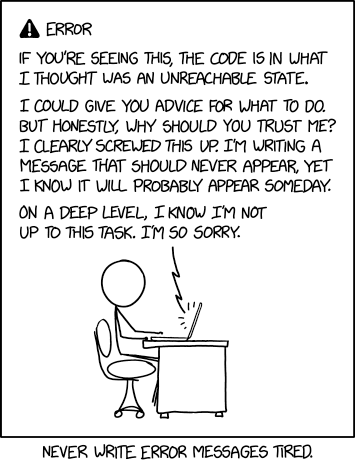

In [4]:
#to visit the comic 
#https://xkcd.com/2200
# hot link
url="https://imgs.xkcd.com/comics/unreachable_state.png"
from IPython.display import Image
Image(url)